## Group 5 Final Presentation - Vanilla CNN and Fine-Tune VGG16 - for Vegetable Classification

- Nathan Garrity (Student number: 8767594)
- Jun He (Student number: 8903073)

### **Introduction**

#### Framing the Problem

This notebook's goal is to train and fine tune a CNN (VGG16) to predict images of different vegetables, then evaluate our findings based on our models results.

- This project uses a dataset from kaggle with hundreds of images of vegetables
- After this intoduction, we will explore the data, such as the number of files split between the training, test and validation folders, image dimensions, etc
- After Data Exploration, we will train, and fine tune a VGG16 model to best fit our image data properly
- We will evaluate the preformance of the best model. We'll look into accuracy, confusion metric, precision, recall, F1-score, precision-recall curve for the model.
- We will explore examples in which our models failed to predict correctly.

### **Data Exploration**

##### Dataset (Source: [Vegetable Image Dataset](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset/data))

The dataset contains 21000 images unique images of 15 different classes. I have modified the dataset and reduced the classes to 10 for training purposes.

Image classes in dataset:
- Bean
- Broccoli
- Cabbage
- Capsicum
- Carrot
- Cauliflower
- Cucumber
- Potato
- Pumpkin
- Tomato

I have **reduced the dataset to 2000 images for training (200 in each class), 2000 for testing, and 1000 for validation (100 in each class)**. 

#### Get the Data:

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [43]:
# Project Configuration
class ProjectConfig:
    def __init__(self):
        self.dataset_path = 'data/kaggle_vegetables_small'
        self.image_size = (224, 224)
        self.batch_size = 32
        self.epochs = 50
        self.learning_rate = 1e-4
        self.models = ['VGG16', 'ResNet50', 'Custom CNN']


In [44]:
# Data Preprocessing
class DataPreprocessor:
    def __init__(self, config):
        self.config = config
    
    def load_dataset(self):
        """
        Load and organize vegetable image dataset
        """
        # Use ImageDataGenerator for efficient data loading
        # Data Augmentation for training set
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2
        )

        
        # Load training and validation data
        train_generator = train_datagen.flow_from_directory(
            self.config.dataset_path,
            target_size=self.config.image_size,
            batch_size=self.config.batch_size,
            class_mode='categorical',
            subset='training'
        )
        
        validation_generator = train_datagen.flow_from_directory(
            self.config.dataset_path,
            target_size=self.config.image_size,
            batch_size=self.config.batch_size,
            class_mode='categorical',
            subset='validation'
        )

       
        
        return train_generator, validation_generator


In [45]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
'data/kaggle_vegetables_small/train',
image_size=(224, 224),
batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
 'data/kaggle_vegetables_small/validation',
image_size=(224, 224),
batch_size=32
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
'data/kaggle_vegetables_small/test',
image_size=(224, 224),
batch_size=32
)

Found 2000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


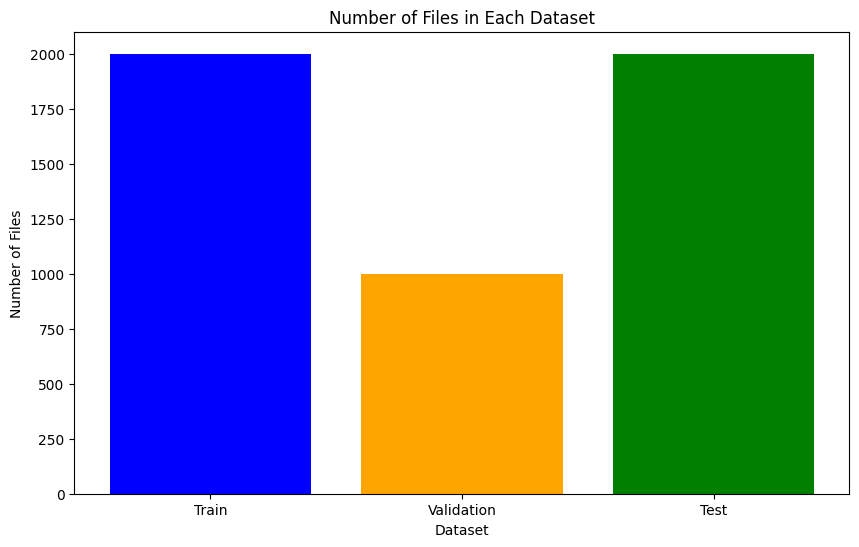

In [46]:
import matplotlib.pyplot as plt
# Function to count the number of files in a dataset
def count_files(dataset):
    count = 0
    for _ in dataset.unbatch():
        count += 1
    return count

# Get the number of files in each dataset
train_files = count_files(train_dataset)
validation_files = count_files(validation_dataset)
test_files = count_files(test_dataset)

# Plot the number of files using a bar chart
datasets = ['Train', 'Validation', 'Test']
file_counts = [train_files, validation_files, test_files]

plt.figure(figsize=(10, 6))
plt.bar(datasets, file_counts, color=['blue', 'orange', 'green'])
plt.title('Number of Files in Each Dataset')
plt.xlabel('Dataset')
plt.ylabel('Number of Files')
plt.show()

### **Data Preprocessing**

### **Modeling**

In [ ]:
# Model Development
class ModelDevelopment:
    def __init__(self, train_generator, validation_generator, config):
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.config = config
        self.models = {}
    
    def build_transfer_learning_model(self, base_model_name='VGG16'):
        """
        Build transfer learning models with flexible architecture
        """
        print(f"current model:{base_model_name}")
        # Load the base VGG16 model
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        # Base model selection
        if base_model_name == 'VGG16':
            base_model = VGG16(weights='imagenet', include_top=False, 
                               input_shape=self.config.image_size + (3,))
        elif base_model_name == 'ResNet50':
            base_model = ResNet50(weights='imagenet', include_top=False, 
                                  input_shape=self.config.image_size + (3,))
        
        # Freeze base model layers initially
        for layer in base_model.layers:
            layer.trainable = False
        
        # Add custom classification layers
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        
        # Output layer (dynamically set number of classes)
        output_layer = Dense(
            len(self.train_generator.class_indices), 
            activation='softmax'
        )(x)
        
        model = Model(inputs=base_model.input, outputs=output_layer)
        
        # Compile with advanced optimizers
        optimizer = Adam(learning_rate=self.config.learning_rate)
        # Alternative: RMSprop(learning_rate=self.config.learning_rate)
        
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_model(self, model):
        """
        Train model with advanced callbacks
        """
        # Learning rate reduction
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2,
            patience=5, 
            min_lr=1e-6
        )
        
        # Early stopping
        early_stop = EarlyStopping(
            monitor='val_accuracy', 
            patience=10,
            restore_best_weights=True
        )
        # ---------------------------------------
        # Model Training
        # ---------------------------------------
        # Model training
        history = model.fit(
            self.train_generator,
            validation_data=self.validation_generator,
            epochs=self.config.epochs,
            callbacks=[reduce_lr, early_stop]
        )
        
        return history

In [48]:
class ModelEvaluation:
    def __init__(self, model, validation_generator):
        self.model = model
        self.validation_generator = validation_generator
    
    def evaluate_model(self):
        """
        Comprehensive model evaluation
        """
        # Evaluate on validation data
        evaluation = self.model.evaluate(self.validation_generator)
        
        # Generate confusion matrix
        predictions = self.model.predict(self.validation_generator)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = self.validation_generator.classes

        # Classification report
        class_labels = list(self.validation_generator.class_indices.keys())
        report = classification_report(true_classes, predicted_classes, target_names=class_labels)
        print("\nClassification Report:\n")
        print(report)
        
        # Visualization methods
        self.plot_confusion_matrix(true_classes, predicted_classes)
        self.plot_training_history()
    
    def plot_confusion_matrix(self, true_classes, predicted_classes):
        """
        Generate and plot confusion matrix
        """
        cm = tf.math.confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(10, 8))
        class_labels = list(self.validation_generator.class_indices.keys())
        sns.heatmap(cm, annot=True, fmt='d',cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    def plot_training_history(self):
        """
        Visualize training and validation metrics
        """
        # Plotting code for accuracy and loss
        



Overfitting is not evident here, both training and validation accuracy stay consistant and follows a similar trend to one another. 

## **Evaluation**

Neural Network Evaluation:

Found 4000 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.
$current model:{base_model_name}
Epoch 1/50
125/125 [==============================] - 183s 1s/step - loss: 1.1381 - accuracy: 0.3767 - val_loss: 1.0564 - val_accuracy: 0.4020 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - 135s 1s/step - loss: 1.0942 - accuracy: 0.3850 - val_loss: 1.0542 - val_accuracy: 0.4040 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - 138s 1s/step - loss: 1.0839 - accuracy: 0.3898 - val_loss: 1.0567 - val_accuracy: 0.3950 - lr: 1.0000e-04
Epoch 4/50
125/125 [==============================] - 137s 1s/step - loss: 1.0770 - accuracy: 0.3945 - val_loss: 1.0566 - val_accuracy: 0.4170 - lr: 1.0000e-04
Epoch 5/50
125/125 [==============================] - 144s 1s/step - loss: 1.0690 - accuracy: 0.4045 - val_loss: 1.0582 - val_accuracy: 0.3930 - lr: 1.0000e-04
Epoch 6/50
125/125 [==============================] - 135s 1s/step - loss: 1.0626 -

e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

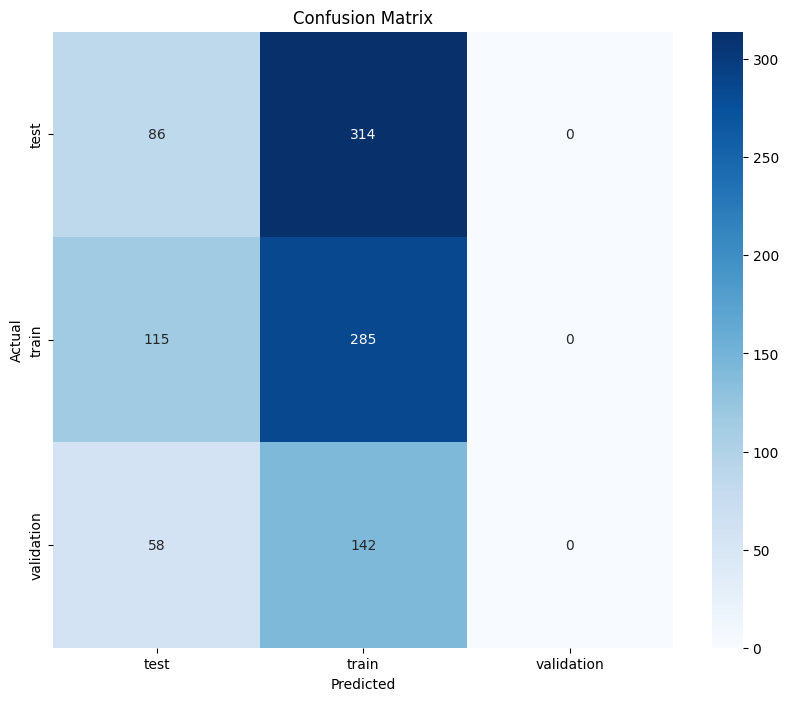

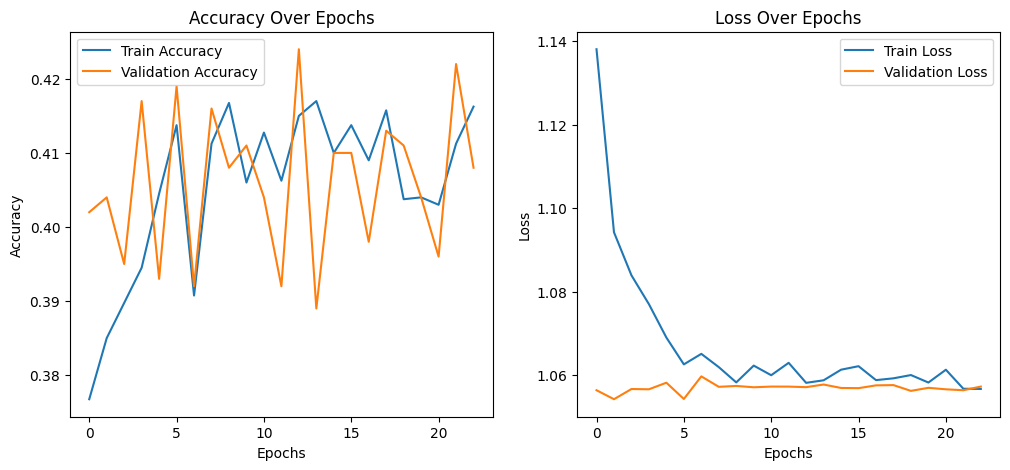

$current model:{base_model_name}
Epoch 1/50
125/125 [==============================] - 96s 754ms/step - loss: 1.1842 - accuracy: 0.3815 - val_loss: 1.0686 - val_accuracy: 0.4010 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - 93s 747ms/step - loss: 1.0959 - accuracy: 0.3902 - val_loss: 1.0561 - val_accuracy: 0.3920 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - 94s 750ms/step - loss: 1.0816 - accuracy: 0.3935 - val_loss: 1.0532 - val_accuracy: 0.4090 - lr: 1.0000e-04
Epoch 4/50
125/125 [==============================] - 93s 748ms/step - loss: 1.0686 - accuracy: 0.4035 - val_loss: 1.0568 - val_accuracy: 0.3780 - lr: 1.0000e-04
Epoch 5/50
125/125 [==============================] - 93s 746ms/step - loss: 1.0676 - accuracy: 0.3935 - val_loss: 1.0558 - val_accuracy: 0.3990 - lr: 1.0000e-04
Epoch 6/50
125/125 [==============================] - 94s 752ms/step - loss: 1.0647 - accuracy: 0.4075 - val_loss: 1.0560 - val_accuracy: 0.4000 - lr: 1.0000

e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

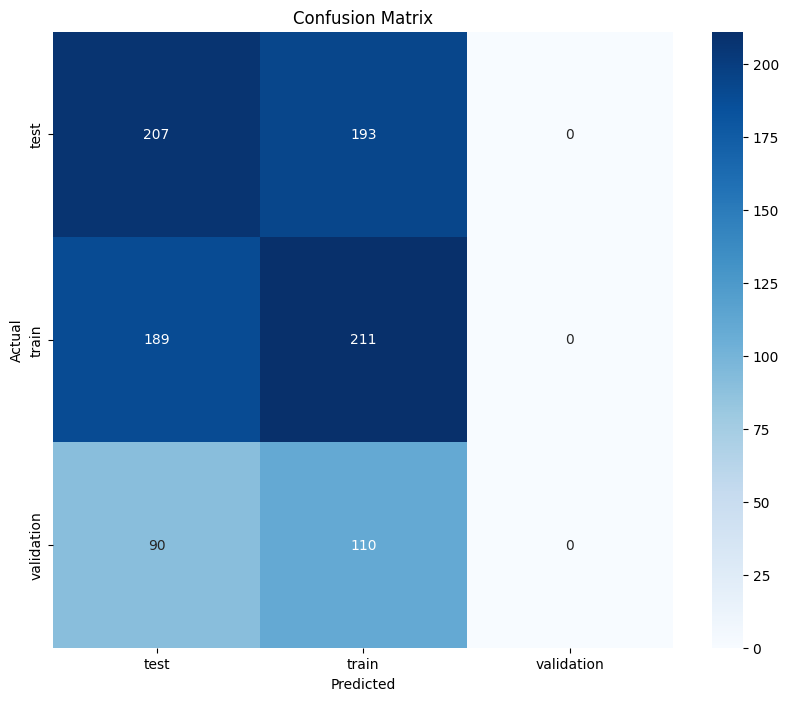

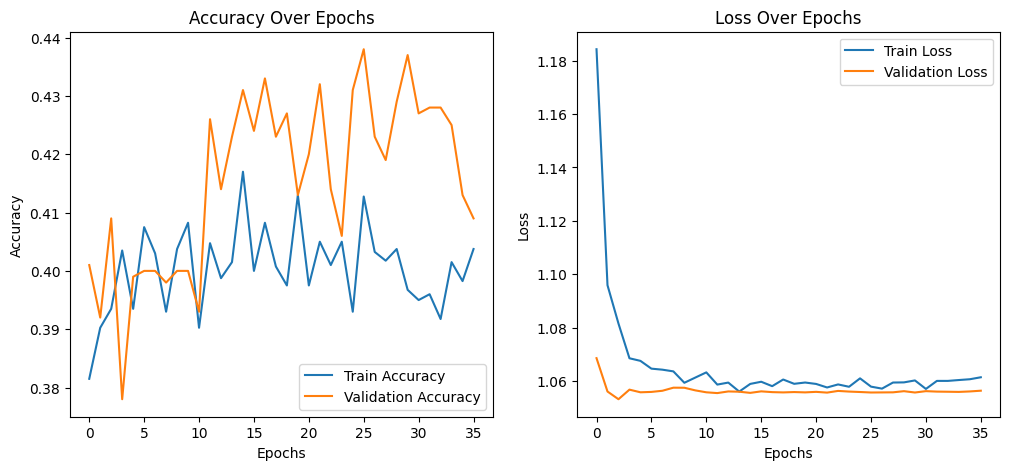

$current model:{base_model_name}
Epoch 1/50
125/125 [==============================] - 142s 1s/step - loss: 1.1225 - accuracy: 0.3828 - val_loss: 1.0595 - val_accuracy: 0.4110 - lr: 1.0000e-04
Epoch 2/50
125/125 [==============================] - 139s 1s/step - loss: 1.0942 - accuracy: 0.3920 - val_loss: 1.0553 - val_accuracy: 0.4040 - lr: 1.0000e-04
Epoch 3/50
125/125 [==============================] - 140s 1s/step - loss: 1.0762 - accuracy: 0.3985 - val_loss: 1.0533 - val_accuracy: 0.4240 - lr: 1.0000e-04
Epoch 4/50
125/125 [==============================] - 139s 1s/step - loss: 1.0753 - accuracy: 0.3945 - val_loss: 1.0563 - val_accuracy: 0.4080 - lr: 1.0000e-04
Epoch 5/50
125/125 [==============================] - 140s 1s/step - loss: 1.0656 - accuracy: 0.4083 - val_loss: 1.0549 - val_accuracy: 0.4230 - lr: 1.0000e-04
Epoch 6/50
125/125 [==============================] - 141s 1s/step - loss: 1.0676 - accuracy: 0.4140 - val_loss: 1.0585 - val_accuracy: 0.4180 - lr: 1.0000e-04
Epoch 7

e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\OneDrive - Conestoga College\AI\AI-labs\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

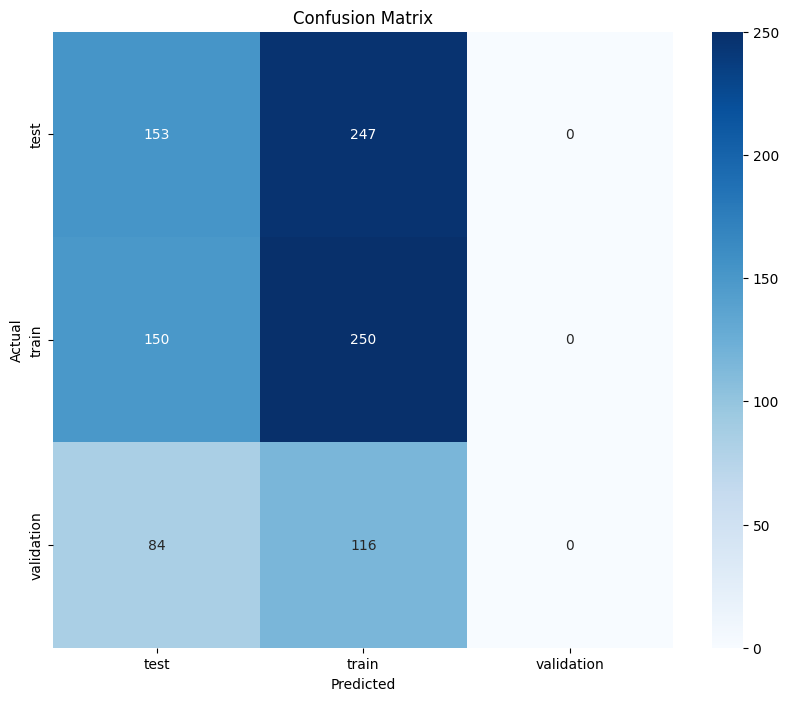

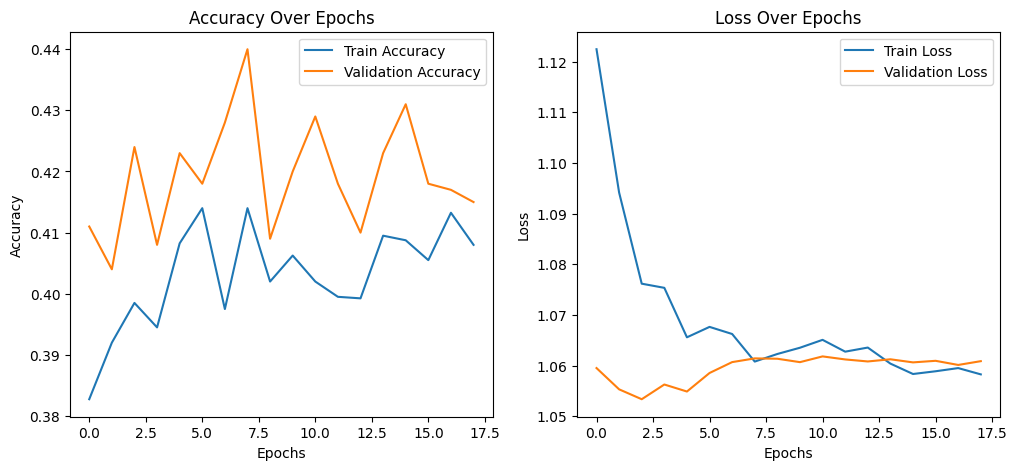

In [49]:
# Main Execution
def main():
    # Project initialization
    config = ProjectConfig()
    preprocessor = DataPreprocessor(config)
    
    # Data preparation
    train_generator, validation_generator = preprocessor.load_dataset()
    
    # Model development
    model_dev = ModelDevelopment(
        train_generator, 
        validation_generator, 
        config
    )
    
    # Train multiple models
    models = {}
    for model_name in config.models:
        model = model_dev.build_transfer_learning_model(model_name)
        history = model_dev.train_model(model)
        
        # Evaluate model
        evaluator = ModelEvaluation(model, validation_generator)
        evaluator.evaluate_model()
        # Plot training and validation accuracy
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Over Epochs')

        # Plot training and validation loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Over Epochs')
        plt.show()

if __name__ == '__main__':
    main()